# Regression with Morgan Fingerprints

## Predicting LogS and LogP Using Circular Fingerprints

---

### Notebook Overview

This notebook demonstrates **regression** using **Morgan (circular) fingerprints** to predict both aqueous solubility (LogS) and partition coefficient (LogP). Morgan fingerprints represent a more advanced and flexible approach to molecular representation compared to MACCS keys.

**Learning Objectives:**
- Understand Morgan (circular/ECFP) fingerprints and their design
- Learn the difference between Morgan and MACCS fingerprints
- Generate Morgan fingerprints with configurable radius and size
- Apply separate Decision Tree regression models for LogS and LogP with Morgan fingerprints
- Compare Morgan fingerprint performance with other representations
- Understand hyperparameters: radius and fingerprint size

**Dataset:** ESOL - 1,128 organic compounds with measured solubility (LogS) and calculated lipophilicity (LogP)

**Task:** Separate regression models for LogS and LogP using Morgan fingerprints as input features

---

### What are Morgan Fingerprints?

**Morgan fingerprints** (also known as **circular fingerprints** or **ECFP - Extended Connectivity Fingerprints**) are based on the Morgan algorithm, which explores the local chemical environment around each atom.

**Key Characteristics:**

**Algorithm:**
- Start at each atom in the molecule
- Iteratively explore neighboring atoms up to a specified radius
- Hash the local environment into a fingerprint bit
- Each bit represents a specific substructure pattern

**Parameters:**
- **Radius:** Controls the size of atomic neighborhoods (0, 1, 2, 3, ...)
  - Radius 0: Individual atoms
  - Radius 1: Atoms + immediate neighbors
  - Radius 2: Atoms + neighbors + neighbors' neighbors
  - Radius 3: Extended local environment
- **Fingerprint Size:** Total number of bits (512, 1024, 2048, 4096, ...)
  - Larger size reduces collision probability
  - Common choice: 2048 bits

**Example:**
```
Radius 1 fingerprint captures:
- C-C bond
- C=O group
- N-H bond
- Aromatic C in 6-membered ring
```

**Structure:**
- **Length:** Configurable (typically 1024 or 2048 bits)
- **Type:** Binary (0 or 1)
- **Encoding:** Presence/absence of hashed substructure patterns
- **Sparsity:** Usually sparse (many zeros)

---

### Morgan vs MACCS Fingerprints

Understanding the differences helps choose the right representation:

| Aspect | Morgan Fingerprints | MACCS Keys |
|--------|-------------------|------------|
| **Design** | Algorithmic (data-driven) | Predefined structural keys |
| **Length** | Configurable (512-4096+) | Fixed (166 bits) |
| **Features** | Hashed substructures | Specific chemical groups |
| **Flexibility** | High (radius, size tunable) | Low (fixed definitions) |
| **Interpretability** | Low (hashed patterns) | High (known substructures) |
| **Redundancy** | Potential hash collisions | No collisions |
| **Use case** | General-purpose, large datasets | Smaller datasets, interpretability |

**When to use Morgan:**
- Need flexibility in feature engineering
- Large, diverse molecular datasets
- Sufficient data to avoid overfitting

**When to use MACCS:**
- Interpretability is critical
- Smaller datasets
- Well-defined structural features matter

---

### Morgan Fingerprint Parameters

**Radius selection:**

- **Radius 1:**
  - Captures immediate atom neighborhoods
  - Good for local property prediction
  - Less prone to overfitting

- **Radius 2:**
  - Most commonly used
  - Balances locality and broader context
  - Standard for many applications

- **Radius 3:**
  - Captures larger substructures
  - May overfit on small datasets
  - Useful for complex properties

**Size selection:**

- **1024 bits:** Faster computation, more collisions
- **2048 bits:** Good balance (most common)
- **4096 bits:** Fewer collisions, slower, needs more data

**Note:** In this notebook, we use radius=1 and fpSize=2048

---

### Target Properties

**LogS (Aqueous Solubility)**

**LogP (Partition Coefficient)**

---

## 1. Import Required Libraries

We import libraries for:
- **Data manipulation:** pandas, numpy
- **Machine Learning:** scikit-learn (DecisionTreeRegressor, metrics, train_test_split)
- **Chemical informatics:** RDKit (Chem, Descriptors, fingerprint generators)
- **Visualization:** matplotlib

**Key RDKit imports:**
- `Chem`: Core molecular operations
- `GetMorganGenerator`: Modern Morgan fingerprint generator (RDKit 2023+)
- `Descriptors.MolLogP`: For calculating LogP values

In [ ]:
import pandas as pd                      # For data manipulation and handling DataFrames
import numpy as np                       # For numerical operations
import requests                          # To download the dataset from a URL
from io import StringIO                  # To treat the downloaded CSV text as a file-like object

!pip install rdkit

from rdkit import Chem                   # RDKit core for handling molecules (parsing SMILES)
from rdkit.Chem import Crippen           # To compute logP values using RDKit
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator,AdditionalOutput  # To generate Morgan fingerprints

from sklearn.model_selection import train_test_split  # To split the dataset into training and testing sets
from sklearn.tree import DecisionTreeRegressor        # The regression model used in this notebook
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating the model's performance
from sklearn.preprocessing import StandardScaler      # For normalizing features before training
from sklearn.pipeline import Pipeline                 # To chain preprocessing and modeling steps cleanly

import matplotlib.pyplot as plt          # For visualizing predicted vs actual values


---

## 2. Load the ESOL Dataset

### 2.1 Dataset Loading

The ESOL dataset provides:
- SMILES strings (molecular structure notation)
- Measured LogS values (aqueous solubility)
- Various pre-computed molecular properties

We extract SMILES and LogS for our analysis.

In [ ]:
def load_esol_dataset():
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)                                                    # Fetch
    response.raise_for_status()                                                     # Ensure the request was successful
    df = pd.read_csv(StringIO(response.text))                                       # Read CSV from the URL
    print(f"Loaded ESOL with {len(df)} compounds")
    df = df[['smiles', 'measured log solubility in mols per litre']]                # Select relevant columns
    df.columns = ['SMILES', 'LogS']
    valid_smiles = [Chem.MolFromSmiles(s) is not None for s in df['SMILES']]        # Filter valid SMILES
    df = df[valid_smiles].reset_index(drop=True)                                    # Reset index after filtering
    return df

df = load_esol_dataset()
df.head()


Loaded ESOL with 1128 compounds


,SMILES,LogS
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


### 2.2 Compute LogP Values

Since ESOL does not include LogP, we calculate it using RDKit's MolLogP descriptor.

**Process:**
1. Parse each SMILES string to create molecule object
2. Calculate LogP using `Descriptors.MolLogP()` (Wildman-Crippen method)
3. Add LogP column to DataFrame

**Result:** DataFrame with columns [SMILES, LogS, LogP]

In [ ]:
# Compute logP (octanol-water partition coefficient) using RDKit
logP_values = []
for smiles in df['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    logp = Crippen.MolLogP(mol)             # Calculate logP using RDKit's Crippen module
    logP_values.append(logp)

df['logP'] = logP_values                    # Add logP values to the DataFrame
df.head()
print("Computed logP values.")

Computed logP values.


---

## 3. Generate Morgan Fingerprints

### 3.1 Morgan Fingerprint Generator Setup

We use RDKit's modern `GetMorganGenerator` API to create Morgan fingerprints.

**Generator Configuration:**
- **radius=1:** Captures immediate atomic neighborhoods (ECFP2-like)
- **fpSize=2048:** 2048-bit fingerprint vector

**Why these parameters?**

**Radius 1 chosen because:**
- Suitable for property prediction on medium-sized datasets
- Captures essential local chemical environments

**Size 2048 chosen because:**
- Standard size in cheminformatics
- Reduces hash collisions compared to 1024
- Not too large to cause sparsity issues
- Well-tested in literature

**Alternative configurations to explore:**
- radius=2, fpSize=2048 (ECFP4, most common)
- radius=1, fpSize=1024 (faster, more collisions)
- radius=3, fpSize=4096 (larger substructures, needs more data)

### 3.2 Apply Fingerprint Generation

We convert all SMILES to Morgan fingerprints and prepare features for training separate models.

**Steps:**
1. Initialize Morgan generator with chosen parameters
2. For each SMILES, generate 2048-bit fingerprint
3. Convert fingerprints to numpy arrays
4. Create feature matrix X (n_samples, 2048)
5. For each target (LogS and LogP separately):
   - Create target vector y (n_samples,)
   - Split into 80% train / 20% test

**Data shapes (for each target):**
- **X_train:** (n_train, 2048) - Binary Morgan fingerprint features
- **y_train:** (n_train,) - Single target (either LogS or LogP)
- **X_test:** (n_test, 2048) - Test fingerprints
- **y_test:** (n_test,) - Test target values

**Note:** The fingerprint is sparse - most bits are 0, only a subset are 1.

In [ ]:
morgan_gen = GetMorganGenerator(radius=1, fpSize=2048) # Can adjust radius and size

def smiles_to_morgan(smiles):                               # Function to convert SMILES to Morgan fingerprints
    mol = Chem.MolFromSmiles(smiles)
    fp = morgan_gen.GetFingerprint(mol)
    return np.array(fp)

fps = np.array([smiles_to_morgan(s) for s in df['SMILES']])  # Generate Morgan fingerprints for each SMILES
print("Generated Morgan fingerprints.")

Generated Morgan fingerprints.


### Visualising a bit in Morgan Fingerprint

In [ ]:
epinephrine = Chem.MolFromSmiles('CNC[C@H](O)c1ccc(O)c(O)c1')
fpg = GetMorganGenerator(radius=2)
ao = AdditionalOutput()
ao.AllocateBitInfoMap()

fp = fpg.GetFingerprint(epinephrine,additionalOutput=ao)
list(fp.GetOnBits())[:10]

[1, 80, 227, 315, 589, 606, 632, 807, 875, 1057]

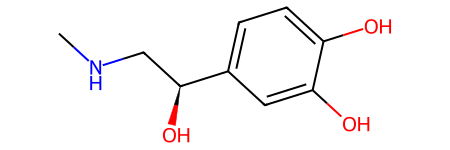

In [ ]:
epinephrine

**Visualising a substructure corresponding to a bit in the fingerprint**
Try out different bits and what

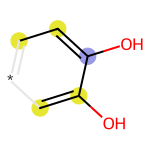

In [ ]:
from rdkit.Chem import Draw
Draw.DrawMorganBit(epinephrine,315,ao.GetBitInfoMap())

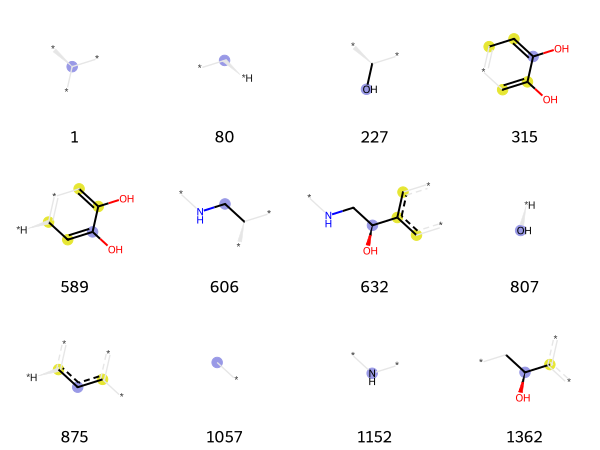

In [ ]:
tpls = [(epinephrine,x,ao.GetBitInfoMap()) for x in fp.GetOnBits()]
Draw.DrawMorganBits(tpls[:12],molsPerRow=4,legends=[str(x) for x in fp.GetOnBits()][:12])

---

## 4. Train Decision Tree Regressors

### 4.1 Model Training

We train separate Decision Tree models to predict LogS and LogP from Morgan fingerprints.

**Model Configuration:**
- **Algorithm:** DecisionTreeRegressor
- **Input features:** 2048 binary Morgan fingerprint bits
- **Output target:** 1 continuous value (LogS or LogP)
- **Splitting criterion:** MSE (minimizes variance)
- **Random state:** 42 (ensures reproducibility)

**How Decision Trees Handle Binary Features:**

Binary fingerprint features are ideal for Decision Trees:
- **Natural splits:** "Is bit 523 = 1?" (does substructure exist?)
- **No scaling needed:** Binary values already normalized
- **Interpretable logic:** Presence/absence of structural patterns
- **Efficient computation:** Fast boolean comparisons

**Training Process:**
1. Initialize Decision Tree regressor for each target
2. For LogS:
   - Fit on training data (X_train, y_train_LogS)
   - Tree learns which Morgan bits predict LogS
3. For LogP:
   - Fit on training data (X_train, y_train_LogP)
   - Tree learns which Morgan bits predict LogP
4. Models ready for prediction on new molecules


===== Regression on LogS =====
MSE: 1.8227
R2: 0.6144


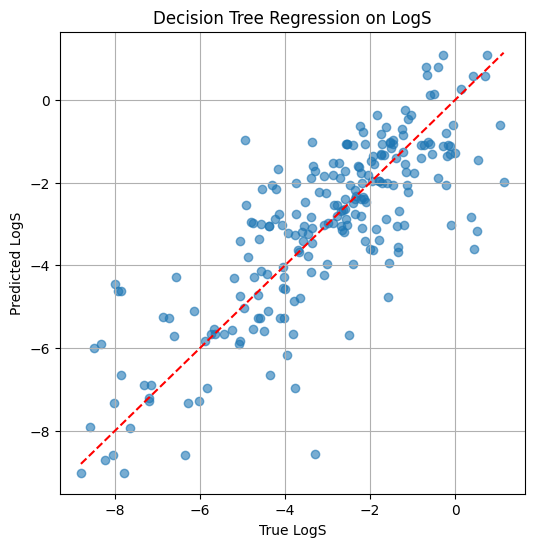


===== Regression on logP =====
MSE: 1.4079
R2: 0.6190


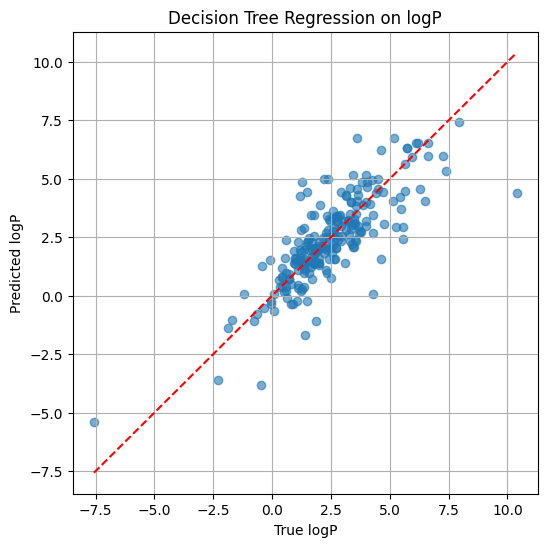

In [ ]:

# We will evaluate regression on both LogS and logP
targets = {'LogS': df['LogS'].values, 'logP': df['logP'].values}

# Loop through each target
for target_name, y in targets.items():
    print(f"\n===== Regression on {target_name} =====")

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        fps, y, test_size=0.2, random_state=42
    )

    model = DecisionTreeRegressor(random_state=42)


    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Evaluate model performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")

    # Plot predicted vs actual values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel(f"True {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Decision Tree Regression on {target_name}")
    plt.grid(True)
    plt.show()

### 4.2 Model Evaluation

We evaluate performance on the held-out test set for each target separately.

**Evaluation Metrics:**

For each target (LogP and LogS), we compute:

- **R² Score (Coefficient of Determination)**

- **MSE (Mean Squared Error)**

The loop in the code trains and evaluates a separate model for each property.

---

## 5. Results and Analysis

### 5.1 Feature Importance Analysis

Unlike molecular descriptors, Morgan fingerprint bits are less interpretable. For each trained model, you can analyze which bits were most important:

```python
# Get feature importances for a specific model (e.g., LogS model)
importances = model.feature_importances_

# Find most important bits
top_indices = np.argsort(importances)[-20:][::-1]

print("Top 20 most important Morgan fingerprint bits:")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. Bit {idx}: Importance {importances[idx]:.4f}")

# Analyze sparsity
non_zero_importances = np.sum(importances > 0)
print(f"\nNumber of features used: {non_zero_importances} / 2048")
print(f"Sparsity: {(2048 - non_zero_importances) / 2048 * 100:.1f}%")
```

**Interpretation:**
- Important bits correspond to substructures critical for the specific property
- Many bits may have zero importance (not all patterns relevant)
- High importance suggests that hashed pattern strongly affects the property
- Cannot easily reverse-engineer what each bit represents (hash collision)
- Different models (LogS vs LogP) may rely on different substructural patterns


### 5.2 Comparison: Morgan vs MACCS vs Descriptors

**Trade-offs:**

**Morgan Fingerprints:**
- Advantages: High information content, flexible, state-of-the-art
- Disadvantages: Low interpretability, needs more data, hash collisions

**MACCS Keys:**
- Advantages: Interpretable, efficient, good baseline
- Disadvantages: Fixed features, limited flexibility, less information

**Molecular Descriptors:**
- Advantages: Directly interpretable, physically meaningful, low-dimensional
- Disadvantages: May miss structural information, limited to computed properties
---

## 6. Summary and Key Takeaways

### Key Insights

**About Morgan Fingerprints:**
- Algorithmic approach based on atomic neighborhoods
- Configurable via radius and fingerprint size
- Captures local chemical environments through hashing
- More flexible and informative than MACCS keys
- Standard tool in modern cheminformatics

**About Feature Representation:**
- Morgan fingerprints provide richer structural information
- Trade-off between information content and interpretability
- Higher dimensionality requires sufficient training data
- Binary features well-suited for tree-based models